1. Изображение загружено
   Размер: (400, 600)


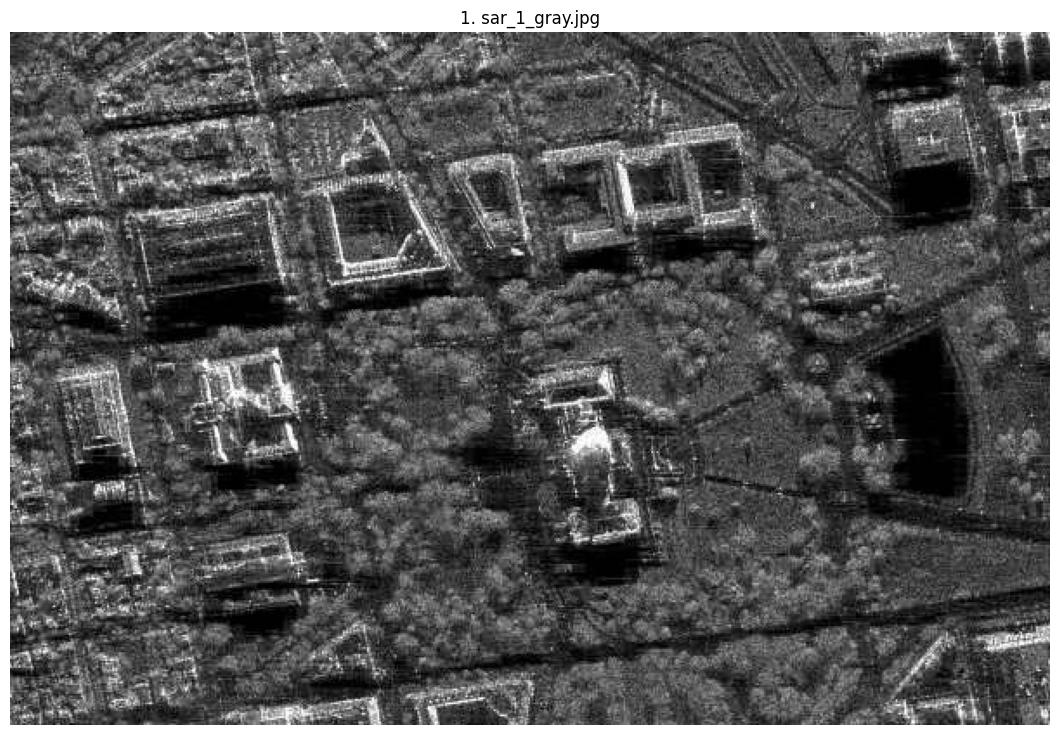

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Markdown as md

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)

img = cv2.imread('sar_1_gray.jpg', cv2.IMREAD_GRAYSCALE)
if img is None:
    raise FileNotFoundError("sar_1_gray.jpg не найден!")

print("1. Изображение загружено")
print(f"   Размер: {img.shape}")
plt.imshow(img, cmap='gray')
plt.title('1. sar_1_gray.jpg')
plt.axis('off')
plt.show()

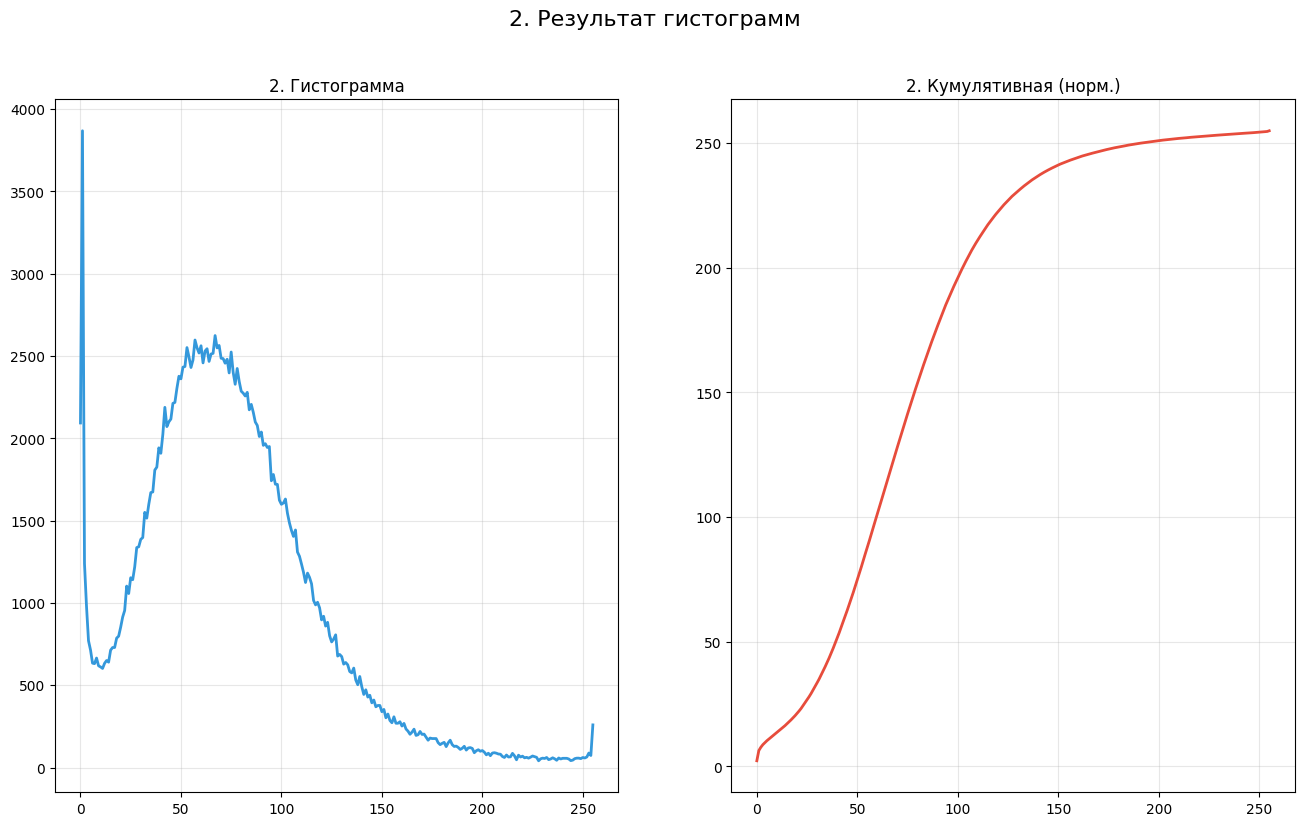

2. Гистограммы построены


In [2]:
#Гистограмма
hist = cv2.calcHist([img], [0], None, [256], [0, 256])
cdf = hist.cumsum()
cdf_norm = cdf * 255 / cdf[-1]

plt.figure()
plt.subplot(1,2,1)
plt.plot(hist, color='#3498db', linewidth=2)
plt.title('2. Гистограмма')
plt.grid(alpha=0.3)

plt.subplot(1,2,2)
plt.plot(cdf_norm, color='#e74c3c', linewidth=2)
plt.title('2. Кумулятивная (норм.)')
plt.grid(alpha=0.3)

plt.suptitle('2. Результат гистограмм', fontsize=16)
plt.show()

print("2. Гистограммы построены")

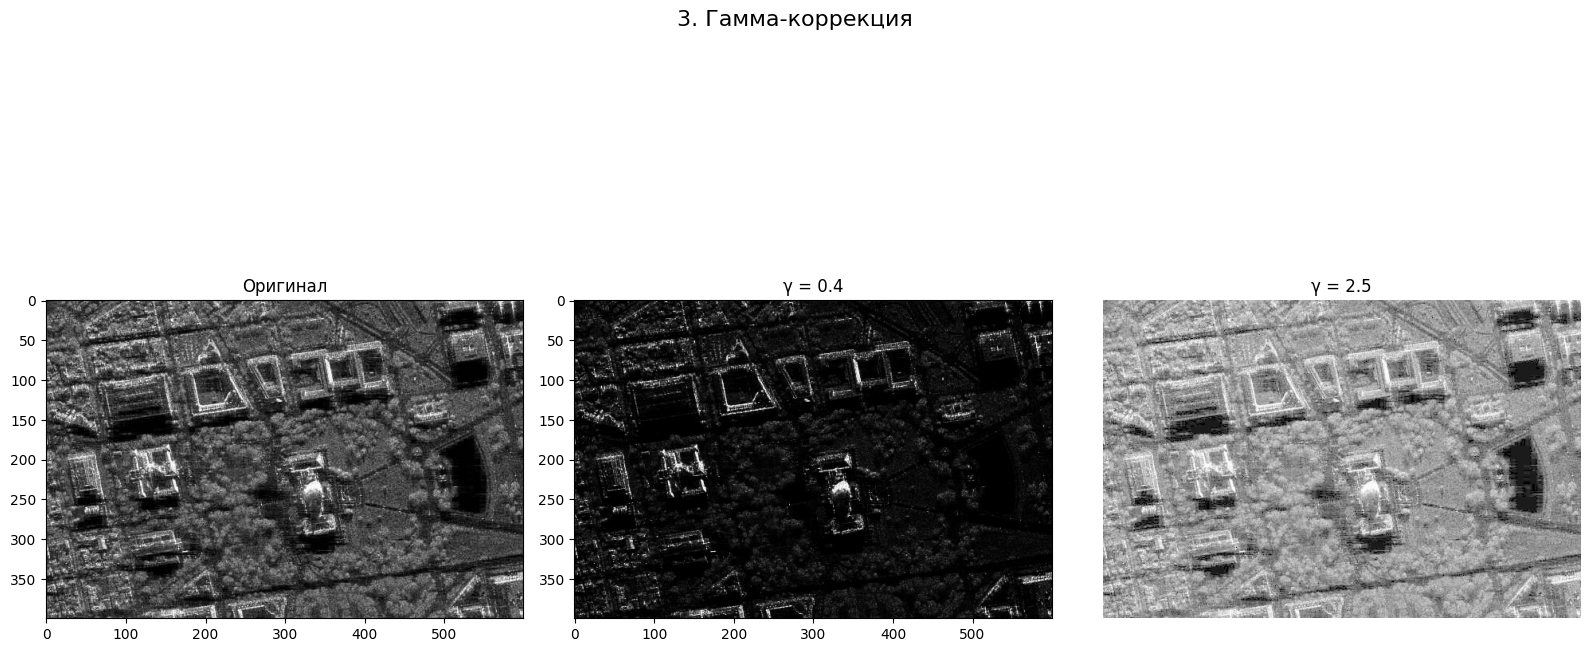

3. Гамма-коррекция выполнена


In [3]:
#Гамма
def gamma_transform(image, gamma):
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(256)])
    return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))

gamma_04 = gamma_transform(img, 0.4)
gamma_25 = gamma_transform(img, 2.5)

plt.figure()
plt.subplot(1,3,1); plt.imshow(img, cmap='gray'); plt.title('Оригинал')
plt.subplot(1,3,2); plt.imshow(gamma_04, cmap='gray'); plt.title('γ = 0.4')
plt.subplot(1,3,3); plt.imshow(gamma_25, cmap='gray'); plt.title('γ = 2.5')
plt.suptitle('3. Гамма-коррекция', fontsize=16)
plt.axis('off'); plt.tight_layout(); plt.show()

print("3. Гамма-коррекция выполнена")

In [4]:
#MSE + SSIM
def mse(a, b):
    return np.mean((a.astype(np.float64) - b.astype(np.float64)) ** 2)

def ssim_manual(img1, img2):
    C1 = (0.01 * 255) ** 2
    C2 = (0.03 * 255) ** 2
    
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.T)
    
    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    
    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2
    mu1_mu2 = mu1 * mu2
    
    sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1*img2, -1, window)[5:-5, 5:-5] - mu1_mu2
    
    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()

mse1 = mse(img, gamma_04)
mse2 = mse(img, gamma_25)
ssim1 = ssim_manual(img, gamma_04)
ssim2 = ssim_manual(img, gamma_25)

print("4. Сравнение гамма-изображений:")
print(f"{'γ':<5} {'MSE':<12} {'SSIM':<8}")
print(f"{'0.4':<5} {mse1:<12.2f} {ssim1:<8.4f}")
print(f"{'2.5':<5} {mse2:<12.2f} {ssim2:<8.4f}")

4. Сравнение гамма-изображений:
γ     MSE          SSIM    
0.4   3563.42      0.3189  
2.5   5531.44      0.7060  


5. Статистическая цветокоррекция выполнена
   Исходное:            mean = 74.94,  std = 43.38
   cv2.equalizeHist:    mean = 127.32,  std = 74.09
   После коррекции:     mean = 123.44,  std = 65.20


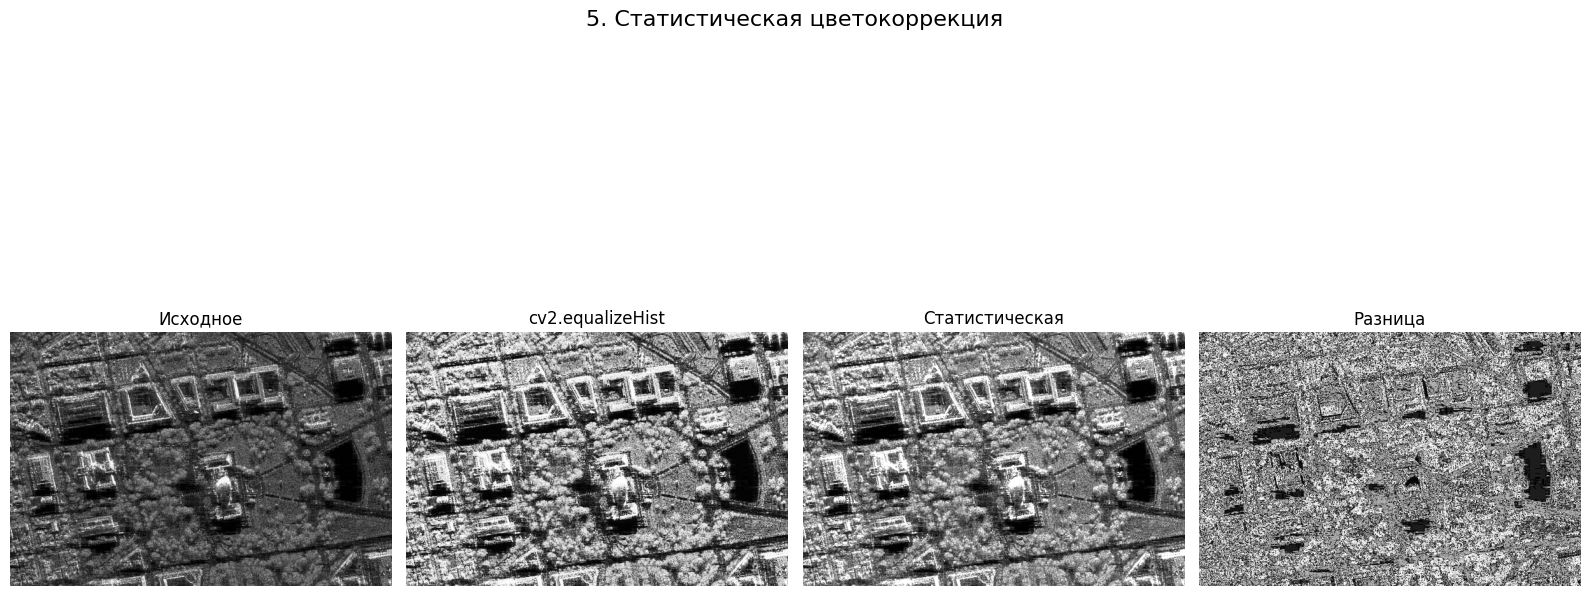

In [5]:
# 5. Статистическая цветокоррекция
eq_cv = cv2.equalizeHist(img)                        

target_mean = eq_cv.mean()                           
target_std  = eq_cv.std()                             

current_mean = img.mean()
current_std  = img.std()

# Линейное преобразование
stat_corrected = (img.astype(np.float32) - current_mean) * (target_std / (current_std + 1e-6)) + target_mean
stat_corrected = np.clip(stat_corrected, 0, 255).astype(np.uint8)

# Выводим числовые результаты
print("5. Статистическая цветокоррекция выполнена")
print(f"   Исходное:            mean = {current_mean:.2f},  std = {current_std:.2f}")
print(f"   cv2.equalizeHist:    mean = {target_mean:.2f},  std = {target_std:.2f}")
print(f"   После коррекции:     mean = {stat_corrected.mean():.2f},  std = {stat_corrected.std():.2f}")

# Визуализация
plt.figure()
plt.subplot(1,4,1)
plt.imshow(img, cmap='gray')
plt.title('Исходное')
plt.axis('off')

plt.subplot(1,4,2)
plt.imshow(eq_cv, cmap='gray')
plt.title('cv2.equalizeHist')
plt.axis('off')

plt.subplot(1,4,3)
plt.imshow(stat_corrected, cmap='gray')
plt.title('Статистическая')
plt.axis('off')

plt.subplot(1,4,4)
plt.imshow(cv2.absdiff(stat_corrected, eq_cv), cmap='gray')
plt.title('Разница')
plt.axis('off')

plt.suptitle('5. Статистическая цветокоррекция', fontsize=16)
plt.tight_layout()
plt.show()

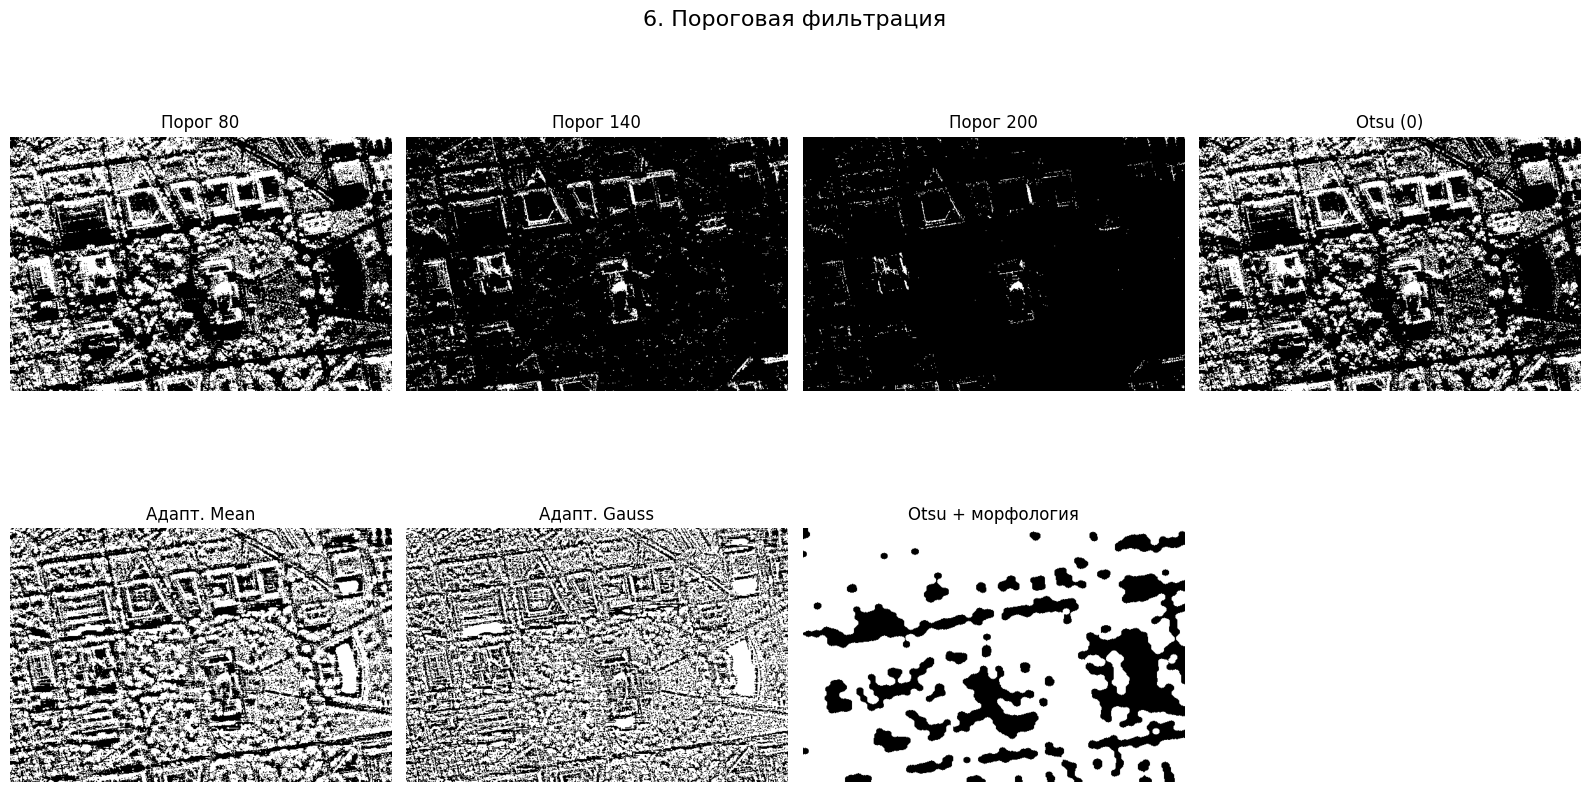

In [6]:
#Пороги
t1 = cv2.threshold(img, 80, 255, cv2.THRESH_BINARY)[1]
t2 = cv2.threshold(img, 140, 255, cv2.THRESH_BINARY)[1]
t3 = cv2.threshold(img, 200, 255, cv2.THRESH_BINARY)[1]
_, otsu = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
adapt1 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 10)
adapt2 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, 10)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
otsu_morph = cv2.morphologyEx(otsu, cv2.MORPH_CLOSE, kernel)
otsu_morph = cv2.morphologyEx(otsu_morph, cv2.MORPH_OPEN, kernel)

results = [t1, t2, t3, otsu, adapt1, adapt2, otsu_morph]
titles = ['Порог 80', 'Порог 140', 'Порог 200', f'Otsu ({cv2.threshold(img,0,255,4)[0]:.0f})', 
          'Адапт. Mean', 'Адапт. Gauss', 'Otsu + морфология']

plt.figure()
for i, (res, title) in enumerate(zip(results, titles)):
    plt.subplot(2, 4, i+1)
    plt.imshow(res, cmap='gray')
    plt.title(title)
    plt.axis('off')
plt.suptitle('6. Пороговая фильтрация', fontsize=16)
plt.tight_layout()
plt.show()